# Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import time
import json
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
from xskillscore import crps_quadrature, crps_ensemble

import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))
from modules.architectures import *

from modules.swag import data, models, utils, losses
from modules.swag.posteriors import SWAG

import modules.architectures as modelArchitectures
from modules.full_pipeline import compute_errors, _inner
from modules.plotting import plot_intervalmap, plot_signal, plot_rmses
from modules.data import hp_to_equiangular
from modules.test import compute_rmse_healpix, compute_R2, compute_rmse_equiangular, compute_weighted_rmse

In [3]:
config_file = 'config_s01_two_steps_small.json'
ep = 11
lead_time = 6

# load config
with open("../configs/" + config_file) as json_data_file:
    cfg = json.load(json_data_file)

# define paths
datadir = cfg['directories']['datadir']
input_dir = datadir + cfg['directories']['input_dir']
model_save_path = datadir + cfg['directories']['model_save_path']
pred_save_path = datadir + cfg['directories']['pred_save_path']
metrics_path = datadir + cfg['directories']['metrics_path']

# model parameters
max_lead_time = cfg['training_constants']['max_lead_time']
len_sqce = cfg['model_parameters']['len_sqce']
delta_t = cfg['model_parameters']['delta_t']
architecture_name = cfg['model_parameters']['architecture_name']
resolution = cfg['model_parameters']['resolution']

lead_times = np.arange(lead_time, max_lead_time+lead_time, lead_time)

In [15]:
def get_spread(description_member, description_member_median, nb_models=10, swag=False):
    ensemble = []
    description = description_member
    for i in range(nb_models):
        if swag:
            description = description.replace(f"model{i}", f"model{i+1}")
        else:
            description = description.replace(f"model{i}", f"model{i+1}")
        pred = xr.open_dataset(pred_save_path + description + '.nc').drop('lat').drop('lon').chunk('auto')
        ensemble.append(pred)
    
    ensemble_median = xr.open_dataset(pred_save_path + description_member_median + '.nc').drop('lat').drop('lon').chunk('auto')
    
    diff = [abs(member - ensemble_median) for member in ensemble]
    diff = xr.concat(diff, dim='member')
    
    dims = list(diff.dims).copy()
    dims.remove('lead_time')
    
    diff_mean = [diff['z'].mean(dims), diff['t'].mean(dims)]
    diff_mean = xr.merge(diff_mean).load()
    
    del ensemble
    del ensemble_median
    
    return diff_mean

# Deep Ensemble

In [5]:
# description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale001_median',
# description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale01_mean',
# description_epoch + f'_s02_swag_freq10_epoch_11_swag_scale03_median',
# description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale00_median',
# description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale01_aggregate_median',

In [6]:
compute = True

In [9]:
obs = xr.open_mfdataset(pred_save_path + 'observations_nearest.nc', combine='by_coords')

description_epoch = "all_const_len{}_delta_{}_architecture_".format(len_sqce, delta_t) + architecture_name

description_members = [
    description_epoch + f'_s02_ensemble_model0_epoch11',
    description_epoch + f'_s02_fixed_data_ensemble_ensemble_model0_epoch11'
]

descriptions_median = [
    description_epoch + f'_s02_ensemble_epoch_{ep}_median',
    description_epoch + f'_s02_fixed_data_ensemble_ensemble_epoch_{ep}_median'
]

if compute:
    spread_rand = get_spread(description_members[0], descriptions_median[0])
    spread_fixed = get_spread(description_members[1], descriptions_median[1])

In [12]:
if compute:
    spread_rand.to_netcdf(datadir + 'metrics/spread_' + descriptions_median[0].replace('_median', '') + '.nc')
    spread_fixed.to_netcdf(datadir + 'metrics/spread_' + descriptions_median[1].replace('_median', '') + '.nc')
else:
    spread_rand = xr.open_dataset(datadir + 'metrics/spread_' + descriptions_median[0].replace('_median', '') + '.nc')
    spred_fixed = xr.open_dataset(datadir + 'metrics/spread_' + descriptions_median[1].replace('_median', '') + '.nc')

In [10]:
rmse_rand_median = xr.open_dataset(datadir + 'metrics/rmse_' + descriptions_median[0] + '.nc')
rmse_fixed_median = xr.open_dataset(datadir + 'metrics/rmse_' + descriptions_median[1] + '.nc')

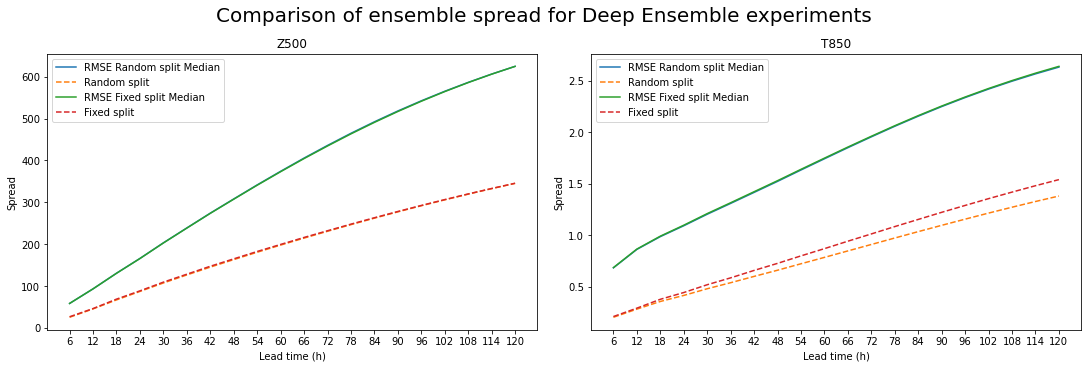

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

ax1.plot(lead_times, rmse_rand_median.z.values, label='RMSE Random split Median')
ax2.plot(lead_times, rmse_rand_median.t.values, label='RMSE Random split Median')

ax1.plot(lead_times, spread_rand.z.values, linestyle='dashed', label='Random split')
ax2.plot(lead_times, spread_rand.t.values, linestyle='dashed', label='Random split')

ax1.plot(lead_times, rmse_fixed_median.z.values, label='RMSE Fixed split Median')
ax2.plot(lead_times, rmse_fixed_median.t.values, label='RMSE Fixed split Median')

ax1.plot(lead_times, spread_fixed.z.values, linestyle='dashed', label='Fixed split')
ax2.plot(lead_times, spread_fixed.t.values, linestyle='dashed', label='Fixed split')

ax1.set_xlabel('Lead time (h)')
ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax2.set_xlabel('Lead time (h)')
ax1.set_ylabel('Spread')
ax2.set_ylabel('Spread')
ax1.set_title('Z500')
ax2.set_title('T850')

f.suptitle('Comparison of ensemble spread for Deep Ensemble experiments', 
           fontsize=20)
ax1.legend()
ax2.legend()
plt.show()

# MultiSWAG

In [13]:
compute = True

In [17]:
obs = xr.open_mfdataset(pred_save_path + 'observations_nearest.nc', combine='by_coords')

description_epoch = "all_const_len{}_delta_{}_architecture_".format(len_sqce, delta_t) + architecture_name

description_members_multiswag = [
    description_epoch + f'_s02_multiswag_ensemble_model1_epoch11_swag_scale00',
    description_epoch + f'_s02_multiswag_ensemble_model1_epoch11_swag_scale01_aggregate'
]

descriptions_median_multiswag = [
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale00_median',
    description_epoch + f'_s02_multiswag_ensemble_epoch_11_swag_scale01_aggregate_median'
]

if compute:
    spread_multiswa = get_spread(description_members_multiswag[0], descriptions_median_multiswag[0])
    spread_multiswa.to_netcdf(datadir + 'metrics/spread_' + descriptions_median_multiswag[0].replace('_median', '') + '.nc')
    
    spread_multiswag = get_spread(description_members_multiswag[1], descriptions_median_multiswag[1])
    spread_multiswag.to_netcdf(datadir + 'metrics/spread_' + descriptions_median_multiswag[1].replace('_median', '') + '.nc')
else:
    spread_multiswa = xr.open_dataset(datadir + 'metrics/spread_' + descriptions_median_multiswag[0].replace('_median', '') + '.nc')
    spread_multiswag = xr.open_dataset(datadir + 'metrics/spread_' + descriptions_median_multiswag[1].replace('_median', '') + '.nc')

In [19]:
rmse_multiswa_median = xr.open_dataset(datadir + 'metrics/rmse_' + descriptions_median_multiswag[0] + '.nc')
rmse_multiswag_median = xr.open_dataset(datadir + 'metrics/rmse_' + descriptions_median_multiswag[1] + '.nc')

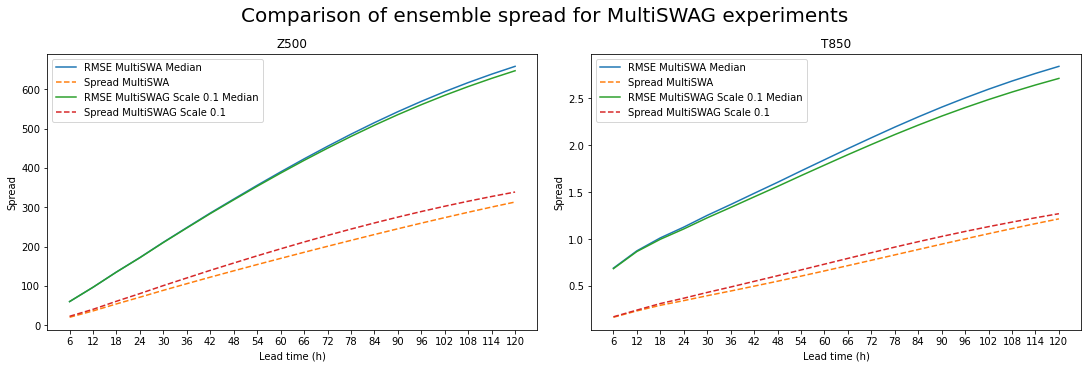

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

ax1.plot(lead_times, rmse_multiswa_median.z.values, label='RMSE MultiSWA Median')
ax2.plot(lead_times, rmse_multiswa_median.t.values, label='RMSE MultiSWA Median')

ax1.plot(lead_times, spread_multiswa.z.values, linestyle='dashed', label='Spread MultiSWA')
ax2.plot(lead_times, spread_multiswa.t.values, linestyle='dashed', label='Spread MultiSWA')

ax1.plot(lead_times, rmse_multiswag_median.z.values, label='RMSE MultiSWAG Scale 0.1 Median')
ax2.plot(lead_times, rmse_multiswag_median.t.values, label='RMSE MultiSWAG Scale 0.1 Median')

ax1.plot(lead_times, spread_multiswag.z.values, linestyle='dashed', label='Spread MultiSWAG Scale 0.1')
ax2.plot(lead_times, spread_multiswag.t.values, linestyle='dashed', label='Spread MultiSWAG Scale 0.1')

ax1.set_xlabel('Lead time (h)')
ax1.set_xticks(lead_times)
ax2.set_xticks(lead_times)
ax2.set_xlabel('Lead time (h)')
ax1.set_ylabel('Spread')
ax2.set_ylabel('Spread')
ax1.set_title('Z500')
ax2.set_title('T850')

f.suptitle('Comparison of ensemble spread for MultiSWAG experiments', 
           fontsize=20)
ax1.legend()
ax2.legend()
plt.show()